In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.svm import OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

In [2]:
# Load data from CSV file into a pandas DataFrame
df = pd.read_csv("merged_zeek_logs.csv")

# Convert the DataFrame to a numpy array
labels = df.pop('label') #labels are separated
binary_labels = (labels == "benign").astype(int)

data_array = df.to_numpy()
print(df.columns)
print(data_array.shape)

Index(['id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'duration',
       'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'is_icmp', 'http_count', 'ssl_count',
       'avg_seen_bytes_files', 'request_body_len', 'response_body_len',
       'dns_answer_count', 'avg_TTL', 'SLD_freq', 'query_length',
       'service_http', 'service_ssl', 'service_no_service', 'conn_state_RSTO',
       'conn_state_RSTR', 'conn_state_S0', 'conn_state_S1', 'conn_state_S3',
       'conn_state_SF', 'conn_state_SH', 'resumed_T', 'resumed_missing',
       'established_T', 'established_missing',
       'validation_status_not_provided', 'validation_status_missing',
       'method_POST', 'method_no_method', 'status_code_101', 'status_code_200',
       'status_code_204', 'status_code_missing', 'TLD_com', 'TLD_ms',
       'TLD_net', 'TLD_missing'],
      dtype='object')
(234, 47)


## Goal and methods
I think the assignment is fit for semi-supervised outlier detection. I want to see, which data is drastically different from the benign data I know, and then assign them as malicious. This will have lesser accuracy compared to full supervised approach with large dataset. The amount of data is also a problem here, since I have less than 240 points, only about  100 of those are known to be benign. 

For outlier detection, we do have several types of models. Autoencoders, Clustering (namely density-based like DBSCAN), Isolation forrest, Local outlier factor, One-class SVM come to mind. I have experience with clustering, decision/regression trees (pointing at the isolation forrest) and SVMs, so I am more likely to use these. I will analyze different models alter to select one or two.

#### Metrics for comparing models
I have to design the goal metric in a away I can measure. There are not as many metrics useful for this task, since it is not fully supervised and I dont have a proper test set/validation data (I cannot use full accuracy, F1 measure and alike). I want to ensure, that (almost) all of the actually benign data are correctly classified as benign. This leads me to Recall (true positive rate) on benign data, which i want to maximize. Recall is how many of the known benign is classified as benign (inlier in my case) by the model. I will explain the used metric more in the notebook.

Here we have amounts of labels given beforehand. All flows which started less than 4 minutes after the beginning of the capture are assumed benign, others are unknown for now.
- label
- unknown    132
- benign     102

In the end, we will call all the known benign data benign, but now we are trying to assert if the unknown samples are possibly also benign or malicious. 

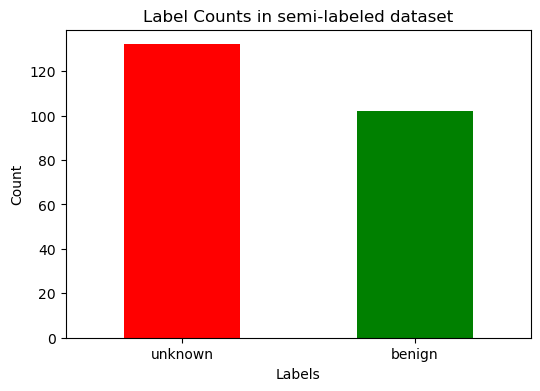

In [3]:
label_counts = labels.value_counts()

label_counts.plot(kind="bar", color=["red", "green"], figsize=(6, 4))
plt.title("Label Counts in semi-labeled dataset")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

## Feature selection, normalisation and dimensionality reduction

I will be using mostly sk-learn classes unless necessary to use something else, because I am familiar with the API and sk-learn offers all of the functionality I need for this.
I want to experiment with different data normalisation, feature selection, visualisation methods, dimensionality reduction and methods of outlier detection. 

Why outlier detection (OD)? I think it is the only useful ML paradigm for this task, because I have not been given all labeled data. I only have "benign" data, and only some of it. Hence, I want to recognize, that data "similar" to benign data is probably benign, and outliers/ radically different data MIGHT be malicious. I think, that in real systems, only a very small amount of traffic is malicious, but we really need to find it. Therefore, I will label everything not similar to my labeled benign as malicious. My system will have a large error, but I want to minimize False-Negative error on class of malicious data, which means capturing a lot of malicious data, but probably taking a lot of benign data with it.

#### Scaling

First before anything, we need to scale the data properly, so we can use other ML techniques.
I have 2 techniques in mind: Zero-mean and min-max normalisation. I would not use min-max here because I think there might be some outliers int he dataset, which could "throw off" scaling of some of the features. I think the dataset is very small and both methods would perform fine here, but zero mean normalisation is my more favourite one. :))

We will try using visualisation technique t-SNE (similar to U-map), which is a non linear-technique (as opposed to PCA for example).


In [4]:
def plot_tsne_with_labels(tsne_results, labels):
    label_colors = labels.map({'benign': 'blue', 'unknown': 'red'})

    plt.figure(figsize=(8, 4))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_colors, s=10, alpha=0.7)
    plt.title("t-SNE Visualization with Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Benign', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Unknown', markerfacecolor='red', markersize=10)
    ], loc="best", frameon=False)
    plt.show()

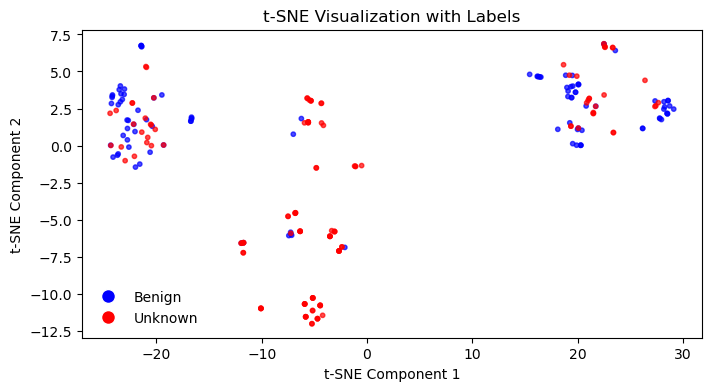

In [5]:
# zero-mean normalization
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_array)

tsne = TSNE(n_components=2, random_state=11111)
tsne_results = tsne.fit_transform(normalized_data)
plot_tsne_with_labels(tsne_results, labels)

Blue points were labeled by me as benign based on provided information. this does not mean the red are all malicious, only that they might be. My thinking is, points close to many benign points are probably also benign?

#### Feature selection

I have 48 columns, but I assume some might have very similar contents (high corellation/colinearity/similarity). We can measure corellation of the columns or use my favourite technique, clustering!
Clustering the columns (features) might reveal similar features, which dont provide enough information. Agglomerative clustering can be used for this.

We do have 48 columns initially. We want smaller number, but if we "compress" the columns too much, then we lose a lot of important variation in the data.
This is also a part of the solution to the curse of dimensionality. We have very few data, hence we want to reduce the number of dimensions to prevent overfitting. Feature selection and dimensionality reduction are a good way to approach this. I'd like to have about 10x as many data as features, leading to about 20-25 features? This also depends on outlier detection technique used.


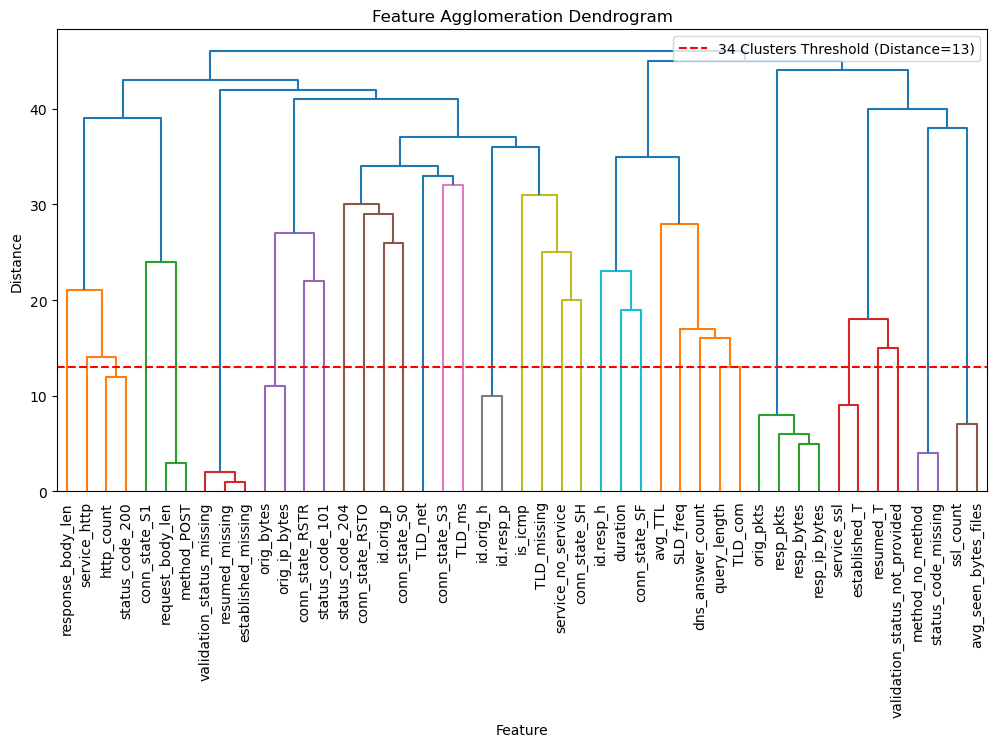

Number of clusters joined below the line: 12


In [6]:
n_clusters =  34
f_agg = cluster.FeatureAgglomeration(
    n_clusters=n_clusters, linkage="ward"
)  # ward, complete, average, single
features_selected_data = f_agg.fit_transform(normalized_data)

n_features = normalized_data.shape[1]  
distances = np.arange(1, f_agg.children_.shape[0] + 1) 
linkage_matrix = np.column_stack(
    [
        f_agg.children_,  # Merging order
        distances,  # Estimated distances
        np.ones(f_agg.children_.shape[0]),  # Cluster sizes (not used but required)
    ]
).astype(float)


# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Feature Agglomeration Dendrogram")
plt.xlabel("Feature")
plt.ylabel("Distance")

# Plot the line for 40 clusters
threshold = distances[-n_clusters]  # Distance at which 40 clusters are formed
plt.axhline(
    y=threshold,
    color="r",
    linestyle="--",
    label=f"{n_clusters} Clusters Threshold (Distance={threshold})",
)

# Count how many clusters were joined below the line
joined_below_line = np.sum(distances < threshold)
plt.legend()
plt.show()

print(f"Number of clusters joined below the line: {joined_below_line}")

Dendrogram shows the order of "joining" of the clusets of features. closer to the bottom, the more similar they were.
We can see, that we have joined some of the features (below the line) and we can see which. This was calculated based on ward linkage (commonly used type of linkage between clusters)
On the vertical line, we can see the ward "distances" between pairs of clusters based on where they meet. Ward linkage is the criterion, which minimizes the variance of clusters being merged. 

We can see, that the closest features are established_missing and returned_missing, meaning those are very often together. There is a similarity between request body length and if the method for http request is POST. Both are 0 if the request is not http request at all. There are more similarities, which can be seen in the dendrogram at the bottom.

It is not clear which type of linkage to choose. I would not choose single linkage, this usually results in a sort of chaining (single linkage joint clusters which have the closest value inbetween some of their data). I used ward, since it is the standard, but average or complete would be good too. Complete is very computation heavy, but we have a small amount of data.

I have selected the amount of clusters by hand. We want less features, but not to distort the data too much. for example I think having http service and code 200 is very much connected, since almost all flows with http connection had code 200. Thats why I decided to merge the last two. This class merged the features in the end by averaging the features in the cluster.

#### Dimensionality Reduction

We aim for around 95% of explained variance ratio (less than that, we are starting to really compress the data and lose a lot of information)
This information means that 95% of the variance of the data is  ůexplained" by the dimensions which we choose to keep.

Explained variance by each component: [1.55422785e-01 1.42173587e-01 1.15951451e-01 5.63093615e-02
 5.24108569e-02 4.36178523e-02 4.00796184e-02 3.47850836e-02
 3.31593107e-02 3.10800176e-02 3.08901657e-02 3.06306044e-02
 3.01297269e-02 2.88035128e-02 2.84873262e-02 2.41450277e-02
 2.08426559e-02 1.82218330e-02 1.52938872e-02 1.38713755e-02
 1.11791193e-02 1.04385701e-02 9.44325432e-03 8.29138576e-03
 5.53575782e-03 3.49495201e-03 2.50366032e-03 1.08398697e-03
 7.90125345e-04 4.77949193e-04 2.95878511e-04 1.59321218e-04
 1.37878936e-32 1.00890565e-33]
Total explained variance: 1.0
Total explained variance cumulative: [0.15542278 0.29759637 0.41354782 0.46985718 0.52226804 0.56588589
 0.60596551 0.6407506  0.67390991 0.70498992 0.73588009 0.76651069
 0.79664042 0.82544393 0.85393126 0.87807629 0.89891894 0.91714078
 0.93243466 0.94630604 0.95748516 0.96792373 0.97736698 0.98565837
 0.99119413 0.99468908 0.99719274 0.99827673 0.99906685 0.9995448
 0.99984068 1.         1.         1.     

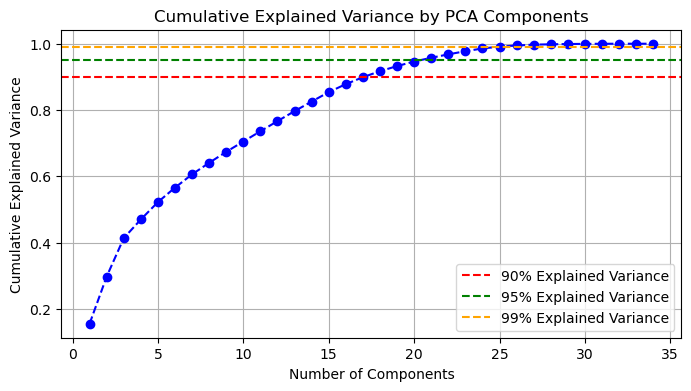

In [7]:
n_components = features_selected_data.shape[1]
pca = PCA(n_components=n_components)
pca.fit(features_selected_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {explained_variance.sum()}")
print(f"Total explained variance cumulative: {explained_variance.cumsum()}")

# Plot the cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(
    np.arange(1, n_components + 1),
    explained_variance.cumsum(),
    marker="o",
    linestyle="--",
    color="b",
)

plt.axhline(y=0.9, color="r", linestyle="--", label="90% Explained Variance")
plt.axhline(y=0.95, color="g", linestyle="--", label="95% Explained Variance")
plt.axhline(y=0.99, color="orange", linestyle="--", label="99% Explained Variance")

plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()

What dimension do we want? we want around 20-25 dimensions, because it is sufficiently low and we retain as much data as possible. We can use explained variance to guide us. In the plot above, we can see if we retain 25 features from the dimensions with the largest variance, we "retain" around 95% od variance. This means abour 5% error? 25 dimensions only have around 1% error. 

We can use an "elbow" rule, we can see between 20 and 25 (approximately), the increase of information levels out and each dimension only helps us very slightly.

`Lets say we want 20 dimensions, so we have a good convergence in the outlier detection algorithms, but dont loose too much information.`

In [8]:
n_components = 20
pca = PCA(n_components=n_components)
pca_data = pca.fit(features_selected_data)

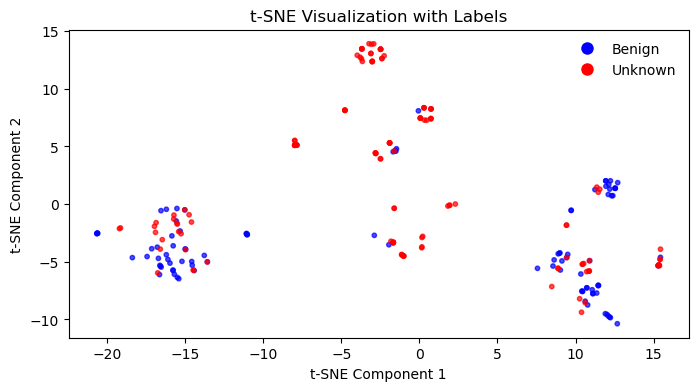

In [9]:
# Plot the t-SNE results with colors based on labels
tsne_results = tsne.fit_transform(pca_data.transform(features_selected_data))
plot_tsne_with_labels(tsne_results, labels)

We can see, that the approximate groups int he data havent changed much in comparison to t-SNE visualisation at the beginning. This was what I assumed was gaing to happen. We didnt make any major changes to the data, just merged some similar features and then removed a small amount of information via PCA (but remnoved many dimensions). t-SNE is non-linear meaning it maps the data onto some kind of non-linear "bent" space (to put it very bluntly). The positions of the groups has changed, but the relative proximity of neighboring points did not really change much when converting from 20 to 2 dimensions. 

## Outlier detection
Finally, we can get to finding the outliers!
We know one thing which unsupervised outlier detection does not know. for some of the data, we have the benign label. Most methods, like Local Outlier Factor take the data as all the same and can classify even known benign data as outliers, because they are so different from others in the dataset. I want to use knowledge of some labels to separate more probable outliers. 

#### Idea 1: Clustering 
I think I can use clustering for my use-case, since I can use the knowledge of known benign data to classify clusters. Density based clustering is an option, since it by default can detect outliers as not being in any cluster. I have found few examples with other clustering methods or novel clustering algorithms made for this use.

`https://www.sciencedirect.com/science/article/pii/S0378475410000510?casa_token=FC78TBrDRHUAAAAA:bK-R44T17g-e6q1V8sCaKoEHr-xqN56lNtzNOTFdX0UfS2VY9cG6byDc24Y7VawLNCjf_6EVMA`
`https://dl.acm.org/doi/pdf/10.1145/1141277.1141421`

#### Idea 2: One-Class SVM on the benign data
One-class svm but on the known benign data could do the trick? Usually one-class SVM does not handle outliers well (as do most SVMs), but if I train the classifier on only known benign data, other benign data should be also classified correctly? (inside the decision boundary). SVM can help me "order" the data by how far are they from the decision boundary (far from the boundary = more outlier). Second option: data which is not inside the decision boundary will be presented as outliers. This approach has a problem, we effectively only use around 100 data points for training, since we dont have more with a label. Usually we would use all points regardless of a label, but I feel we would not use the available information about some benign data this way.

#### Idea 3: Isolation forrest and tuning a threshold
Isolation forrest provides anomaly score for each point (lower score, higher abnormality in sk-learn). We can tune some threshold to then "pick out" only certain amount of the most probable outliers. If we can approximate the amount of traffic being malicious, we would think the most probable outliers should be this malicious traffic. If we say 95% of the traffic is benign, we can then set the threshold for outlier coefficient and label only 5% of the traffic as anomalies based on this. Disadvantage: we have to approximate amount of benign traffic. Depending on the setting, we could set the benign fraction to 99% ar 99.9% (on larger datasets). Some attacks, which start many connections would also break this approach (as well as many other outlier detection methods).

.

(there are other useful models: autoencoders, K-NN which I'm quie fond of, but I wanted to research these three approaches more)

.

.

.

### *I will be trying the Idea 2 (One-class SVM)*
Since I have less overall experience with non-cluster methods and I want to try something new. Used model (One-Class SVM form sk-learn) can also conveniently assign scores based on distance form the decision boundary, which will be helpful when calculating my metric of choice (it can be done with clustering too, it is just a bit harder and not intuitive?)
Isolation forrest would be my second model of choice, but tuning one model and dissecting results is a lot of work and I wanted to concentrate on one model and not compare many.


### Parameter tuning and validation metrics

So what does the used validation metric look like exactly, how do i calculate it and how do I interpret this metric?

As stated previously, I want to somehow use True Positive Rate (TPR=TP/(TP+FN)) on the known benign samples to tune the model/ compare solutions. If I only use recall (which is the same as TPR), I always get most performance if I overshoot the threshold. This means if I have isolation forrest give outlier scores to the samples, and I select the lowest as a threshold, all of the samples are classified as inliers, the metric is 1.0, and the classification is not interesting. 
The way I have described the TPR, I am just calculating it on the known benign data, and in a way it is just 1-FPR. I dont know which other data flagged as inliers are actually benign , so it is not a true TPR.
As said before, monitoring only this metric gives me one-sided information, I want to also incorporate information about other thresholds. 

I propose Average Precision where positives are known benigns and negatives are unlabeled (and is assumed they contain some outliers). This metric is to be maximised. It rewards "ranking" outliers lower than the known benign data (lower the rank, more probable to by malicious). I have also considered drawing ROC rate on the known benign data as the positive class.

In [10]:
def visualize_outlier_score(tsne_results, outlier_scores):
    plt.figure(figsize=(8, 4))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=outlier_scores, cmap='coolwarm', s=10, alpha=0.7)
    plt.colorbar(label="Outlier Score")
    plt.title("t-SNE Visualization with Outlier Scores")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

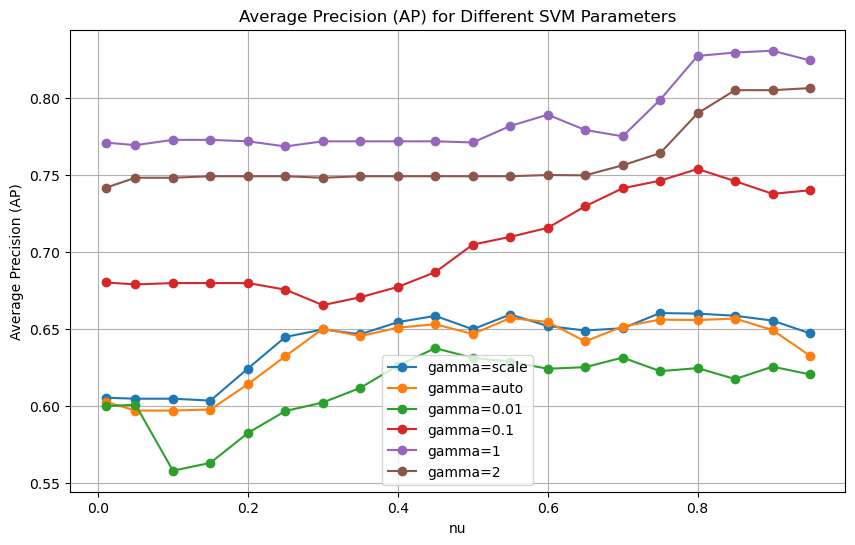

In [11]:
# lets try different values of hyerperparameters
# for OneClassSVM with rbf kernel
# We use K-Fold which separates the data in the same proportion of labels
# and we use the training data to train the model and the test data to evaluate it (with some unseen benign data)
# We use the average precision score to evaluate the model

benign_data = features_selected_data[binary_labels == 1]
nu_values = [0.01, 0.05, 0.1,0.15, 0.2,0.25, 0.3,0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,0.95]
gamma_values = ['scale', 'auto', 0.01, 0.1, 1, 2]
results = []

# Grid search over parameters
for nu in nu_values:
    for gamma in gamma_values:
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        partial_results = []
        for train_idx, test_idx in kfold.split(features_selected_data, binary_labels):
            # Train only on benign examples from the training set.
            train_benign = features_selected_data[train_idx][
                binary_labels[train_idx] == 1
            ]

            oc_svm = OneClassSVM(kernel="rbf", gamma=gamma, nu=nu)
            oc_svm.fit(train_benign)

            # Evaluate on the entire test set
            outlier_scores = oc_svm.decision_function(features_selected_data[test_idx])

            # AP
            average_precision = average_precision_score(
                binary_labels[test_idx], outlier_scores
            )
            partial_results.append(average_precision)
            
        # Average the results over the folds
        average_precision = np.mean(partial_results)
        #print(f"nu: {nu}, gamma: {gamma}, AP: {average_precision:.4f}")
        results.append({"nu": nu, "gamma": gamma, "AP": average_precision})

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
for gamma in gamma_values:
    subset = results_df[results_df['gamma'] == gamma]
    plt.plot(subset['nu'], subset['AP'], marker='o', label=f'gamma={gamma}')

plt.title('Average Precision (AP) for Different SVM Parameters')
plt.xlabel('nu')
plt.ylabel('Average Precision (AP)')
plt.legend()
plt.grid()
plt.show()

Average Precision: 0.9304


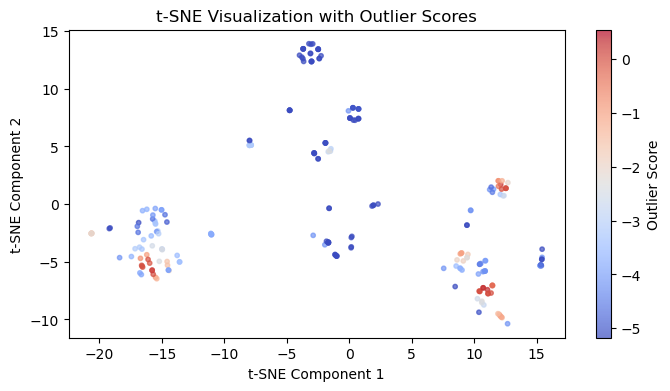

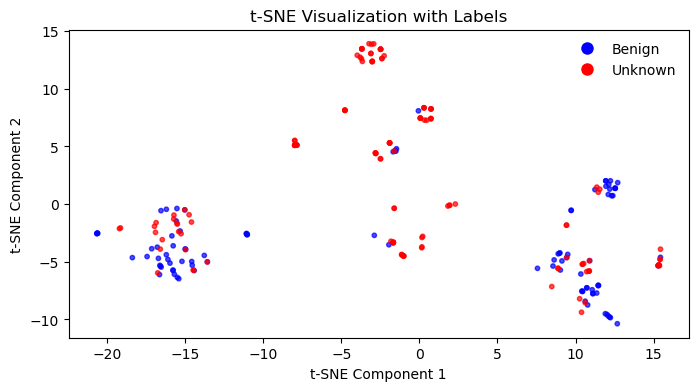

In [12]:
# show one run of the algorithm
oc_svm = OneClassSVM(kernel='rbf', gamma=1, nu=0.9)
oc_svm.fit(features_selected_data[binary_labels == 1]) # all benign data

outlier_scores = oc_svm.decision_function(features_selected_data)
average_precision = average_precision_score(binary_labels, outlier_scores)
print(f"Average Precision: {average_precision:.4f}")

# visualize
visualize_outlier_score(tsne_results, outlier_scores)
plot_tsne_with_labels(tsne_results, labels)

AP is based on ordering of points based on their inlier score (or outlier score). This means if we want to use the best performing model, how do we classify the points?
Well we can use the natural threshold which is provided by the SVM (<0 means outliers, >0 inliers). We dont have a proper validation dataset to find out, which combination parameters separates the data best. I therefore propose another strategy:

##### How to label outliers?
I can use the ordering of points and say 10% is the outliers (or 1%, 5%, 10%, 25% ...) based ony my knowledge of the domain, and just classify the points most probably outliers. This hinges heavily on how well I estimate the percentage of malicious data. It is a known thing, that most of cybersecurity data in "normal" contexts are benign. Small amount of malicious flows would be drowned in a sea of normal connections our moderns computers need to work (periodically ARP, sometimes ICMP, DNS requests any time we want to open a website etc.). I think it is more important to catch malicious data than to not catch truly benign data. The FN on malicious data should in most situations be penalised more than FN on benign data, because many cybersecurity threats are really harsh, while sometimes stopping normal traffic leads to some user discomfort most of the time. 

This is why I think it is better to overshoot the percentage of malicious samples in the data, and aim to separate more traffic as malicious with knowledge, that we will be unfairly classifying some benign traffic as malicious. I will use threshold 10% (final fraction of malicious will be less because of misclassified known benign data.) I also think I'd set the percentage lower, to 5 or 1% if I had more data. Since I know the threat is present in the dataset, and the dataset is small, I can be certain, some portion is malicious.

Note: If my model predicts sample as malicious, but I know it is benign, I re-label the data back to benign at the end.


#### Results

Average Precision: 0.9304
Outlier threshold for top 10%: -5.1769759557861805
Prediction counts:
benign       207
malicious     27
Name: count, dtype: int64

Cross-tabulation of original vs predicted labels:
col_0    benign  malicious
label                     
benign      102          0
unknown     105         27


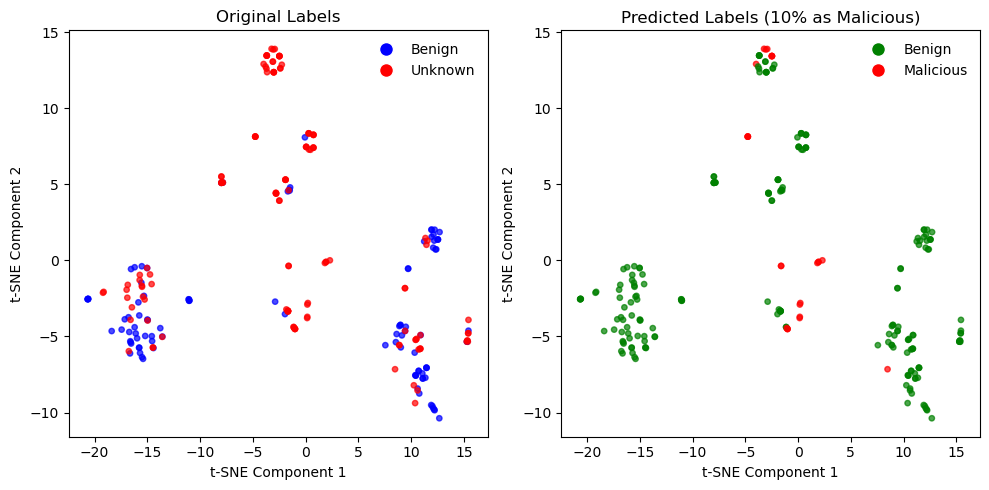

/tmp/ipykernel_276420/2512079422.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


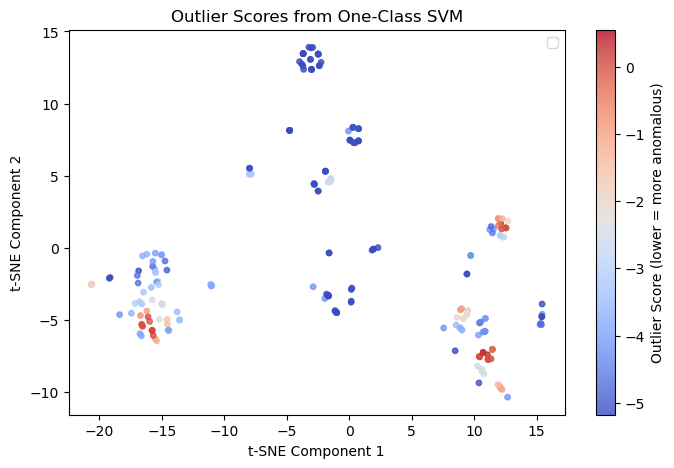

In [13]:
percentage = 10 # set the percentage of data to be considered as outliers

# Train the One-Class SVM with optimized parameters
oc_svm = OneClassSVM(kernel='rbf', gamma=1, nu=0.9) # THE BEST PARAMETERS !!!
oc_svm.fit(features_selected_data[binary_labels == 1]) # all benign data

# Get outlier scores (negative means more likely to be an outlier)
outlier_scores = oc_svm.decision_function(features_selected_data)

average_precision = average_precision_score(binary_labels, outlier_scores)
print(f"Average Precision: {average_precision:.4f}")

# Find threshold for top n% outliers
outlier_threshold = np.percentile(outlier_scores, percentage)
predicted_labels = np.where(outlier_scores <= outlier_threshold, 'malicious', 'benign')
print(f"Outlier threshold for top {percentage}%: {outlier_threshold}")

results_df = pd.DataFrame({
    'original_label': labels,
    'predicted_label': predicted_labels,
    'outlier_score': outlier_scores
})

print("Prediction counts:")
print(pd.Series(predicted_labels).value_counts())
print("\nCross-tabulation of original vs predicted labels:")
print(pd.crosstab(labels, predicted_labels))

# visualize the results
plt.figure(figsize=(10, 5))


# First subplot: original labels
plt.subplot(1, 2, 1)
label_colors = labels.map({'benign': 'blue', 'unknown': 'red'})
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_colors, s=15, alpha=0.7)
plt.title("Original Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Benign', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Unknown', markerfacecolor='red', markersize=10)
], loc="best", frameon=False)

# Second subplot: predicted labels
plt.subplot(1, 2, 2)
pred_colors = pd.Series(predicted_labels).map({"benign": "green", "malicious": "red"})
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=pred_colors, s=15, alpha=0.7)
plt.title(f"Predicted Labels ({percentage}% as Malicious)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Benign', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Malicious', markerfacecolor='red', markersize=10)
], loc="best", frameon=False)

plt.tight_layout()
plt.show()


# Also visualize outlier scores
plt.figure(figsize=(8, 5))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=outlier_scores, cmap='coolwarm', s=15, alpha=0.8)
plt.colorbar(scatter, label="Outlier Score (lower = more anomalous)")
plt.title("Outlier Scores from One-Class SVM")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

In [14]:
# Order the outlier scores from the lowest
ordered_scores = np.sort(outlier_scores)
print("Ordered outlier scores:")
print(ordered_scores)

Ordered outlier scores:
[-5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00 -5.17697596e+00
 -5.17697596e+00 -5.17697595e+00 -5.17697595e+00 -5.17697582e+00
 -5.17695175e+00 -5.17694388e+00 -5.17694388e+00 -5.17694388e+00
 -5.17694388e+00 -5.17694387e+00 -5.17694387e+00 -5.17694387e+00
 -5.17694384e+00 -5.17694098e+00 -5.17694098e+00 -5.17692970e+00
 

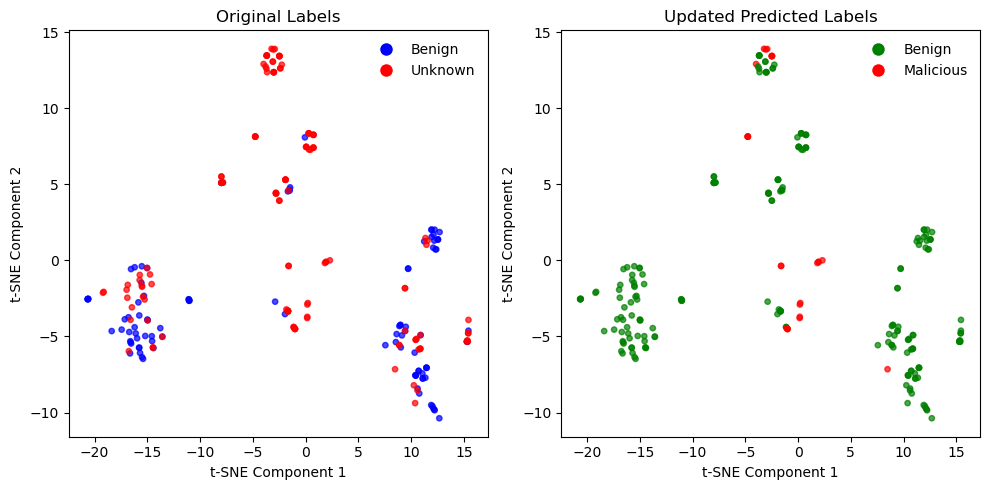

In [15]:
# Relabel known benign points as benign  and compare the graphs
final_labels = predicted_labels.copy()
final_labels[binary_labels == 1] = 'benign'

# Visualize the updated labels
plt.figure(figsize=(10, 5))

# First subplot: original labels
plt.subplot(1, 2, 1)
label_colors = labels.map({'benign': 'blue', 'unknown': 'red'})
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_colors, s=15, alpha=0.7)
plt.title("Original Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Benign', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Unknown', markerfacecolor='red', markersize=10)
], loc="best", frameon=False)

# Second subplot: updated predicted labels
plt.subplot(1, 2, 2)
pred_colors = pd.Series(final_labels).map({"benign": "green", "malicious": "red"})
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=pred_colors, s=15, alpha=0.7)
plt.title("Updated Predicted Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Benign', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Malicious', markerfacecolor='red', markersize=10)
], loc="best", frameon=False)

plt.tight_layout()
plt.show()

Again, Note: the data is visualised using non-linear t-SNE technique. it is possible some "obvious" clusters arent as obvious in the feature space. SVM is classifying in the original feature space and not in this 2D approximation.

In [16]:
with open("final_labels.txt", "w") as file:
    for label in final_labels:
        file.write(f"{label}\n")

print("Final labels saved to 'final_labels.txt'")

# Load the labels from the file and convert them to a numpy array
loaded_labels = np.loadtxt("final_labels.txt", dtype=str)
print("Labels loaded and converted to numpy array.")
print(f"Loaded labels shape: {loaded_labels.shape}")

Final labels saved to 'final_labels.txt'
Labels loaded and converted to numpy array.
Loaded labels shape: (234,)


The labels are stored in order, in which the original network flows are in the conn.log file. If you read the file line by line, and reconstruct the array of labels, you can check my inferred labels against the GP.

In [17]:
labels_loaded = []

with open("final_labels.txt", "r") as file:
    for line in file:
        label = line.strip()
        if label == "benign":
            labels_loaded.append(1)
        else:
            labels_loaded.append(0)

labels_loaded = np.array(labels_loaded)
print("Labels loaded and converted to numpy array.")
print(f"Loaded labels shape: {labels_loaded.shape}")
print("Benign labels: ", np.sum(labels_loaded == 1))
print("Malicious labels: ", np.sum(labels_loaded == 0))

Labels loaded and converted to numpy array.
Loaded labels shape: (234,)
Benign labels:  207
Malicious labels:  27


# Summary:
I first had to merge the logs and select data useful for our models. There was a lot of missing data, which had to be thoughtfully filled in. I had a concern, that some columns might be useless (are very similar to other columns). I wanted to reduce the number of features, since it leads to better covergence of the models and less complexity. I have little data available, hence I need to reduce the number of features as much as possible. I first used agglomerative clustering on normalised features to join groups of similar features, then PCA to reduce by ~ 15 dimensions (less than 5% distortion by the PCA).

Then We could start doing some machine learning. I identified the problem as semi-supervised outlier detection. For this problem there are many algorithms described above. I sketched 3 ideas and then selected one: Use One-Class SVM on the known benign data, then separate the most probable outliers as malicious. I used rbf kernel for the model.

I used K-Fold (10 fold) for validation and grid-search. The optimised metric became Average Precision (AP), explained above. I had a hard time selecting appropriate metric, because the usual supervised metrics wont work here and all metrics I thought of provided only a partial information. AP in my system works on ordered data (ordered by how much outliers they are) and gets higher, if more benign data are higher than unknown (my class 0, negative class).
The resulting model has gamma=1, nu ~ 0.9. For this model I calculated outlier score once. I then had to separate outliers from the inliers. I arbitrarily set threshold to around 10% outliers (with knowledge, that I might overshoot the percentage of possible malicious data). I then labeled the data and saved the resulting labels.

##### Main steps
- Merged logs and selected useful data for modeling.
- Addressed missing data.
- Reduced features using agglomerative clustering and PCA (47->34->20 dimensions).
- Identified the problem as semi-supervised outlier detection.
- Explored three approaches and selected One-Class SVM trained on known benign data.
- Used RBF kernel for the One-Class SVM model.
- Validated using 10-fold cross-validation and grid search.
- Optimized metric: Average Precision (AP) based on outlier ranking.
- Final model parameters: gamma=1, nu~0.9.
- Set threshold to classify ~10% of data as outliers.
- Relabeled known benign data as benign and saved final labels.

Cons of the approach:
- I didnt explore other models, SVMs might not work well with large number of features.
- I have small amount of data.
- Optimised metric might not be complete, need other metrics?
- I dont have any proper test set with labels.
- AP is not very intuitive metric for me.
- Data cleanup took very long.
- I selected columns from the logs by hand, aiming for reduced number of features (my knowledge might not be enough)
  - For example I disregarded x509.log information and threw out most of SSL log. This might be useful when the malware communicates via encrypted connections.
  - My small dataset influenced what I throw out, if I had 10k data, I would keep much more.
- Similarly, I selected number of joined features by hand, with some guidance of my domain knowledge and which columns might be really similar.
- I had to select percentage of outliers by hand. If I am really wrong, this might be very bad for the accuracy of the model.
    - this can be remedied by having a small hand labeled dataset to assert how many of the data are malicious

Pros:
- I used the added labels which might boost the performance.
- I used crossvalidation to prevent overfitting, getting more unbiased estimate of the true power of the model.
- I researched many models and found different ways how I would continue further (clustering, forrests ...)

More work:
- One might try other models
- Different metrics (ROC, just FPR on benign data) might work well in some circumstances
- Optimize parameters of feature selection too?
- obtain labeled sample for validation?
